In [7]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

name = 'Kepler-62 e'
planets = Table.read('../planets2.txt', format='csv', comment='#')
planet = planets[planets['pl_name'] == name][0]
print(planet['pl_name', 'sy_jmag', 'st_teff', 'pl_rade'])

# for Kepler-186 f
#planet['pl_rade'] = 1.438
#planet['pl_radeerr1'] = 0.251

  pl_name   sy_jmag st_teff pl_rade
----------- ------- ------- -------
Kepler-62 e  12.256  4926.0    1.72


In [8]:
import sys
sys.path.append('/Users/tgordon/research/exomoons/forecaster')
import mr_forecast as mr

res = mr.Rstat2M(mean=planet['pl_rade'], std=planet['pl_radeerr1'], unit='Earth', sample_size=1000, grid_size=200)
print(res)

(3.918506784259194, 2.676665281958322, 1.334841909849728)


In [12]:
planet['pl_trandur']

7.123

In [519]:
# for Kepler-62 f
#planet['pl_orbsmax'] = 0.718
#planet['pl_orbeccen'] = 0.0
#planet['pl_tranmid'] = 2455422.71814

# for Kepler-155 c
#planet['pl_orbsmax'] = 0.2254
#planet['pl_orbeccen'] = 0.0
#planet['pl_tranmid'] = 2455016.52113
#planet['st_masserr1'] = 0.05
#planet['st_masserr2'] = -0.05
#planet['pl_trandur'] = 3.136

# for Kepler-186 f
#planet['pl_orbsmax'] = 0.432
#planet['pl_orbeccen'] = 0.0
#planet['pl_tranmid'] = 2455789.49833
#planet['st_masserr1'] = 0.024
#planet['st_masserr2'] = -0.021
#planet['pl_trandur'] = 5.448

# for Kepler-1544 b
#planet['pl_orbeccen'] = 0

In [520]:
mj_ms = 0.0009543
me_ms = 0.000003003
hill = lambda mp, ms, a, e: a * (1 - e) * (mp * me_ms/(3*ms)) ** (1./3.)

pessimistic_hill = hill(res[0]-res[1], planet['st_mass']+planet['st_masserr1'], 
                        planet['pl_orbsmax'], planet['pl_orbeccen'])
optimistic_hill = hill(res[0]+res[2], planet['st_mass']+planet['st_masserr2'], 
                       planet['pl_orbsmax'], planet['pl_orbeccen'])
print("hill radius range: {0} - {1} au".format(pessimistic_hill, optimistic_hill))

hill radius range: 0.01038418336870704 - 0.01802586259267161 au


In [521]:
au_rs = 1/215.032
pess_hill_time = (pessimistic_hill + planet['st_rad'] * au_rs) * planet['pl_orbper'] / (2*np.pi * planet['pl_orbsmax'])
opt_hill_time = (optimistic_hill + planet['st_rad'] * au_rs) * planet['pl_orbper'] / (2*np.pi * planet['pl_orbsmax'])
print("hill sphere transit time range: {0} - {1} hours".format(pess_hill_time*24, opt_hill_time*24))

hill sphere transit time range: 19.488041941421056 - 29.454907662557936 hours


In [522]:
opt_hill_time * 60 * 60 * 24 * 2 / 3

70691.77839013905

In [523]:
phase_range_min = 1 - (planet['pl_trandur']/2 + opt_hill_time/3 + 0.5) / (planet['pl_orbper']*24)
phase_range_max = 1 - (planet['pl_trandur']/2 + opt_hill_time/3 - 0.5) / (planet['pl_orbper']*24)
print("phase range: {0} - {1}".format(phase_range_min, phase_range_max))
print("period: {0}".format(planet['pl_orbper']*24))
print("zero phase: {0}".format(planet['pl_tranmid']))

phase range: 0.9993678660478587 - 0.9995116113943618
period: 6956.746944
zero phase: 2454966.69506


In [451]:
cycle_time = 2.01488 # seconds
total_exposures = ((opt_hill_time * 2 / 3) * 24 * 60 * 60) / cycle_time
print("total exposures: {0}".format(int(total_exposures)))

total exposures: 20178


In [524]:
12067 * 2 / 3

8044.666666666667

In [251]:
import lightkurve as lk
lcfs = lk.search_lightcurvefile(name[:-2], mission='Kepler').download_all()
#lcfs_sc = lk.search_lightcurvefile(name[:-2], mission='Kepler', cadence='short').download_all()
lc = lcfs.PDCSAP_FLUX.stitch()
#lc_sc = lcfs_sc.PDCSAP_FLUX.stitch()

0.00020059575558350248


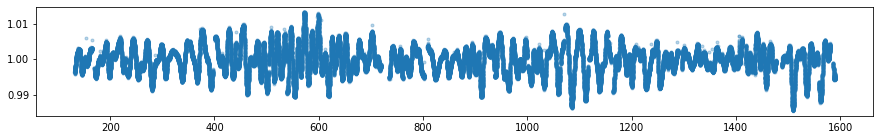

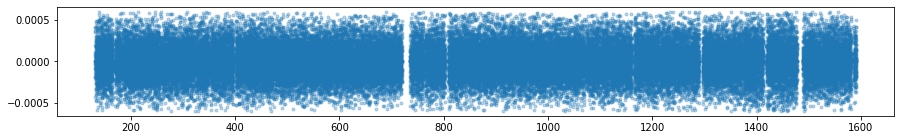

In [252]:
from scipy.signal import medfilt
from astropy.stats import sigma_clip

clipped_lc = lc.remove_outliers(sigma=5)

pl.figure(figsize=(15, 2))
pl.plot(clipped_lc.time, clipped_lc.flux, '.',alpha=0.3)

filtered_flux = clipped_lc.flux - medfilt(clipped_lc.flux, 11)
clipped_filtered_flux = sigma_clip(filtered_flux, sigma=3)
pl.figure(figsize=(15, 2))
pl.plot(clipped_lc.time, clipped_filtered_flux, '.',alpha=0.3)
wn_amp = np.std(clipped_filtered_flux)
print(wn_amp)

In [253]:
w0 = 886

# compute white noise on a timescale of 1/(2 pi w0)
fact = np.min(np.diff(clipped_lc.time)) / (1 / (2*np.pi*w0))
wn_amp_unbinned = wn_amp * np.sqrt(fact)

In [254]:
amp = wn_amp_unbinned / 10
S0 = (amp ** 2) / w0
print(S0)

5.1648616722271564e-11


In [198]:
import celerite2
from celerite2 import terms
term = terms.SHOTerm(S0=S0, w0=w0, Q=1/np.sqrt(2))
gp = celerite2.GaussianProcess(term, mean=0.0)
t = np.linspace(clipped_lc.time[0], clipped_lc.time[-1], len(clipped_lc.time)*10)
gp.compute(t, yerr = 0)
fk = gp.dot_tril(np.random.randn(len(t)))

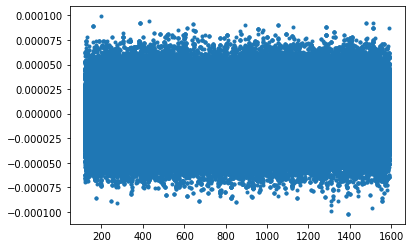

In [200]:
pl.plot(t, medfilt(fk, 11), '.')
#pl.xlim(200, 210)